In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [125]:
df_train = pd.read_csv('output/train.csv')
df_train

,datetime,tmin,tmax,probarain,sun_hours,energie
0,2021-12-01,2,7,60,1,16
1,2021-12-02,0,7,61,2,19
2,2021-12-03,1,8,70,1,19
3,2021-12-04,2,9,76,1,16
4,2021-12-05,3,7,74,1,16
...,...,...,...,...,...,...
847,2024-03-27,6,16,50,4,22
848,2024-03-28,5,15,59,4,18
849,2024-03-29,5,14,46,5,22
850,2024-03-30,6,17,50,7,23


In [126]:
X_train = df_train.drop(columns=['energie', 'datetime'])
y_train = df_train['energie']

In [127]:
df_test = pd.read_csv('output/test.csv')
colonnes_utiles = X_train.columns
df_test = df_test[colonnes_utiles]
df_test

,tmin,tmax,probarain,sun_hours
0,10,17,60,4
1,11,19,50,3
2,13,19,50,3
3,11,16,60,6
4,9,16,60,8
5,9,16,60,8
6,9,17,60,8


In [128]:
df_train.shape

(852, 6)

In [129]:
df_test.shape

(7, 4)

# MODELISATION

Quelques modèles que nous pouvons utiliser sont :
- Regression linéaire
- Bagging
- Boosting

In [130]:
scores_models = {} # pour comparer les models et techniques

### Regression Linéaire

In [131]:
import seaborn as sns
from matplotlib import pyplot

Entrenement du modèle

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

In [133]:
rl_model = LinearRegression()


In [134]:
rl_model.fit(X_train, y_train)

LinearRegression()

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [136]:
y_pred = rl_model.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
r2 = r2_score(y_train,y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 3.1809051212510675
R^2 Score: 0.5408781353154835


In [137]:
scores_models['Reg Linéaire simple'] = r2,

In [138]:
df_score = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
df_score

,Actual,Predicted
0,16,17.368642
1,19,17.806805
2,19,17.120955
3,16,16.848210
4,16,16.438638
...,...,...
847,22,19.943143
848,18,19.355755
849,22,20.143761
850,23,20.864903


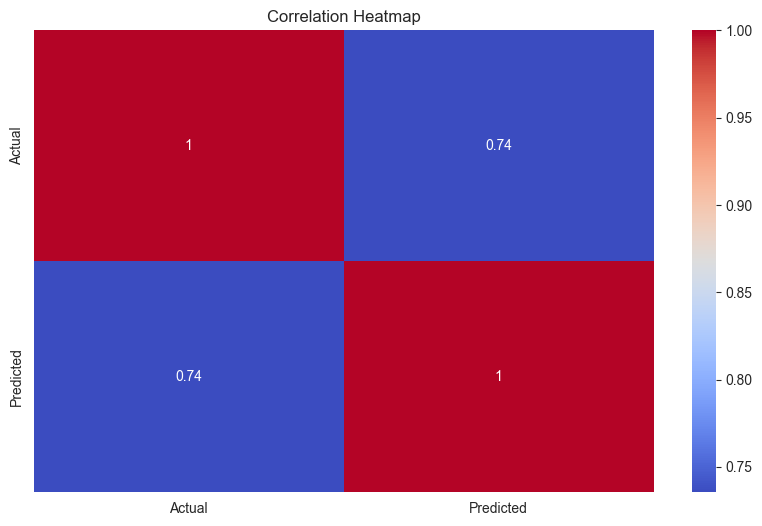

In [139]:
correlation_matrix = df_score.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## AMélioration du Model

### Feature Engineering

In [140]:
def clean_data(X, y):
    # Remplacer les valeurs infinies par des NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprimer les lignes contenant des NaN
    X.dropna(inplace=True)

    # Aligner y avec les indices de X nettoyé
    y = y[X.index]

    return X, y

### Polynomial Features

In [141]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

rl_model = LinearRegression()
rl_model.fit(X_train_poly, y_train)

y_pred = rl_model.predict(X_train_poly)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
scores_models['Polynomial Features'] = np.mean(r2)

Mean Squared Error: 3.0984269671213296
R^2 Score: 0.5527827732962882


### Feature Scaling

In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

rl_model = LinearRegression()
rl_model.fit(X_train_scaled, y_train)

y_pred = rl_model.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
scores_models['Feature Scaling'] = np.mean(r2)


Mean Squared Error: 3.1809051212510684
R^2 Score: 0.5408781353154832


### Regularization Techniques

In [143]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_train)
mse_ridge = mean_squared_error(y_train, y_pred_ridge)
r2_ridge = r2_score(y_train, y_pred_ridge)
print("Ridge Regression - Mean Squared Error:", mse_ridge)
print("R^2 Score:", r2_ridge)
scores_models['Ridge Regression'] = np.mean(r2_ridge)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_train)
mse_lasso = mean_squared_error(y_train, y_pred_lasso)
r2_lasso = r2_score(y_train, y_pred_lasso)
print("Lasso Regression - Mean Squared Error:", mse_lasso)
print("R^2 Score:", r2_lasso)
scores_models['Lasso Regression'] = np.mean(r2_lasso)


Ridge Regression - Mean Squared Error: 3.180905199609543
R^2 Score: 0.5408781240054669
Lasso Regression - Mean Squared Error: 3.198222931336
R^2 Score: 0.5383785369447782


### Cross-Validation

In [144]:
from sklearn.model_selection import cross_val_score

# Evaluation du modèle avec la validation croisée
cv_scores = cross_val_score(rl_model, X_train, y_train, cv=2, scoring='r2')
print("Cross-Validation R^2 Scores:", cv_scores)
print("Mean Cross-Validation R^2 Score:", np.mean(cv_scores))
scores_models['Cross-Validation'] = np.mean(cv_scores)

Cross-Validation R^2 Scores: [0.55097117 0.51751461]
Mean Cross-Validation R^2 Score: 0.5342428908702423


### Ensemble Learning Methods

In [145]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_train)
mse_rf = mean_squared_error(y_train, y_pred_rf)
r2_rf = r2_score(y_train, y_pred_rf)
print("Random Forest - Mean Squared Error:", mse_rf)
print("R^2 Score:", r2_rf)
scores_models['Random Forest'] = r2_rf,

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_train)
mse_gb = mean_squared_error(y_train, y_pred_gb)
r2_gb = r2_score(y_train, y_pred_gb)
print("Gradient Boosting - Mean Squared Error:", mse_gb)
print("R^2 Score:", r2_gb)
scores_models['Gradient Boosting'] = r2_gb,

Random Forest - Mean Squared Error: 0.654818199306454
R^2 Score: 0.9054855956921177
Gradient Boosting - Mean Squared Error: 2.4446386922052503
R^2 Score: 0.6471485215491899


## VISUALISATION DU MODEL LE PLUS QUI EST BON

In [146]:
# on affiche notre evaluation
scores_models

{'Reg Linéaire simple': (0.5408781353154835,),
 'Polynomial Features': 0.5527827732962882,
 'Feature Scaling': 0.5408781353154832,
 'Ridge Regression': 0.5408781240054669,
 'Lasso Regression': 0.5383785369447782,
 'Cross-Validation': 0.5342428908702423,
 'Random Forest': (0.9054855956921177,),
 'Gradient Boosting': (0.6471485215491899,)}

In [147]:
# on represnete le graphique

C:\Users\luis\AppData\Local\Temp\ipykernel_20136\3144051628.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=df_scores, palette='viridis')


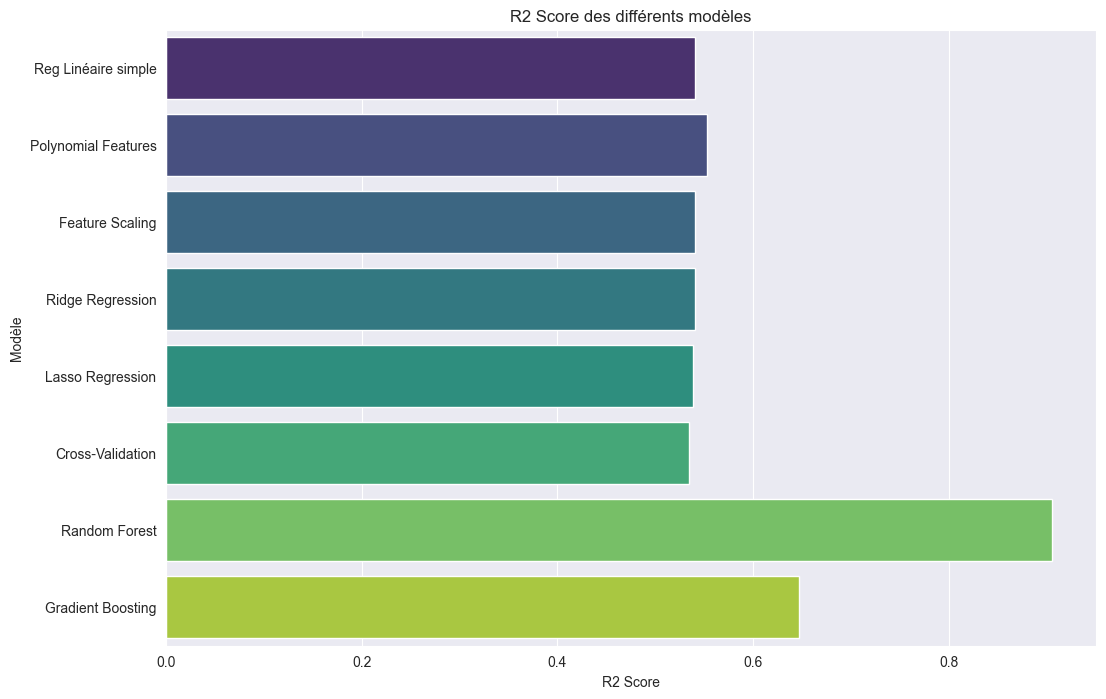

In [148]:
# Convertir le dictionnaire en DataFrame
# Extraire les valeurs si elles sont dans des tuples
data = {'Model': [], 'R2 Score': []}
for key, value in scores_models.items():
    if isinstance(value, tuple):
        value = value[0]
    data['Model'].append(key)
    data['R2 Score'].append(value)

df_scores = pd.DataFrame(data)

# Créer un graphique à barres avec Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='R2 Score', y='Model', data=df_scores, palette='viridis')

# Ajouter un titre et des labels
plt.title('R2 Score des différents modèles')
plt.xlabel('R2 Score')
plt.ylabel('Modèle')

# Afficher le graphique
plt.show()

In [149]:
y_pred_rf_for_week = rf_model.predict(df_test)

In [150]:
df_score = pd.DataFrame({'Predicted': y_pred_rf_for_week})
df_score

,Predicted
0,19.5600
1,19.8000
2,19.6900
3,18.2575
4,18.3775
5,18.3775
6,19.5900


# VISUALISATION DE LA PREDICTION SUR LA METEO DE LA SEMAINE

C:\Users\luis\AppData\Local\Temp\ipykernel_20136\4086352964.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Day", y="Predicted", data=df, palette="viridis")


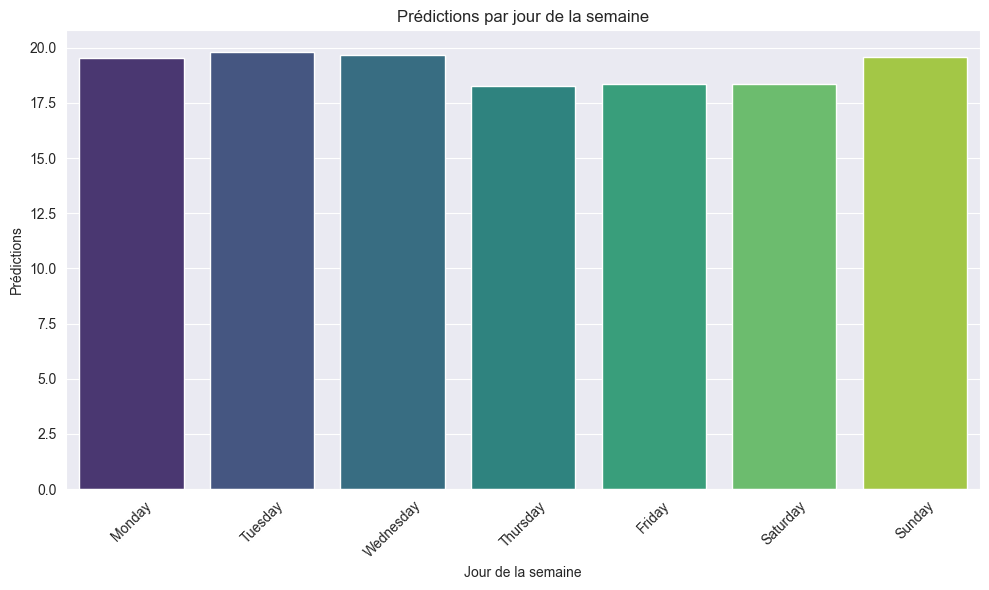

In [151]:
# Données de l'exemple
data = {
    "Predicted": df_score['Predicted'],
    "Day": ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
}

# Créer un DataFrame à partir des données
df = pd.DataFrame(data)

# Créer le graphique en utilisant seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Day", y="Predicted", data=df, palette="viridis")

# Ajouter des titres et des labels
plt.title("Prédictions par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Prédictions")

# Afficher le graphique
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique de la disposition pour éviter la superposition du texte
plt.show()